# Monet Paintings with CycleGAN

## 1. Introduction

In this project, I tried to create new images that looked like Monet paintings using a CycleGAN architecture. At first, I started with a simple GAN setup, but it didn’t work well as the images were either identical or just weird colorful blobs. After some research and experimenting, I decided to use a slightly better CycleGAN setup with small improvements to the generator and discriminator. The goal was to generate more realistic and diverse Monet-style artworks.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from PIL import Image

np.random.seed(123)
tf.random.set_seed(123)

## 2. Preprocessing the Data

I loaded the Monet painting images from the provided Kaggle dataset. Since working with large images can slow down training a lot, I resized them to 128x128 pixels, which still kept enough details for the model to learn. I also normalized pixel values to [-1, 1], which is important when training GANs because it makes it easier for the generator and discriminator to converge.

Shape of dataset: (300, 128, 128, 3)


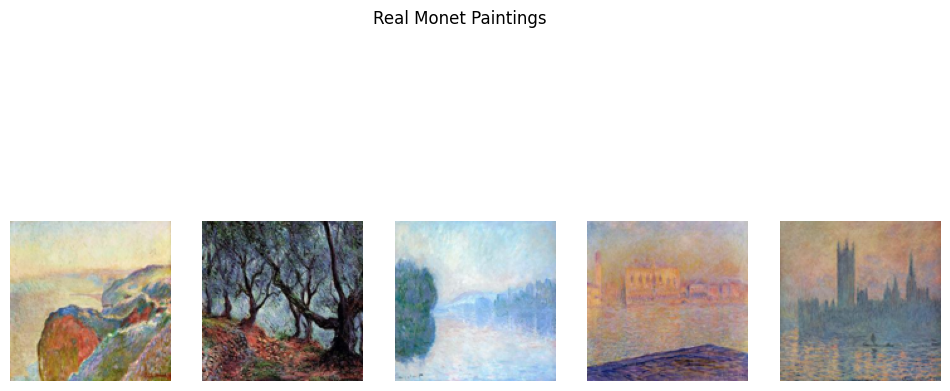

In [24]:
# path to Monet images
monet_path = './data/monet_jpg/'

# load images
image_files = glob.glob(os.path.join(monet_path, '*.jpg'))

def load_and_preprocess(filename):
    img = Image.open(filename).convert('RGB')
    img = img.resize((128, 128))
    img = np.array(img).astype('float32')
    img = (img / 127.5) - 1
    return img

monet_images = np.array([load_and_preprocess(img) for img in image_files])

print("Shape of dataset:", monet_images.shape)

# plot some samples
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow((monet_images[i] + 1) / 2)
    plt.axis('off')
plt.suptitle('Real Monet Paintings')
plt.show()

## 3. Building CycleGAN Models

For the generator, I used a ResNet-based architecture and added Instance Normalization instead of Batch Normalization. InstanceNorm usually works better for style transfer tasks because it normalizes each individual image separately, preserving stylistic details.

For the discriminator, I built a PatchGAN model that looks at small patches (instead of whole images) to decide if they're real or fake. This helps the discriminator focus on local textures, which is super important for making brush strokes and painting details look realistic.

In [25]:
# instance normalization layer
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(name='scale', shape=input_shape[-1:], initializer="ones", trainable=True)
        self.offset = self.add_weight(name='offset', shape=input_shape[-1:], initializer="zeros", trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1,2], keepdims=True)
        return self.scale * (x - mean) / tf.sqrt(variance + self.epsilon) + self.offset

In [26]:
# generator (ResNet blocks)
def resnet_block(x, filters):
    out = layers.Conv2D(filters, (3,3), padding='same')(x)
    out = InstanceNormalization()(out)
    out = layers.ReLU()(out)

    out = layers.Conv2D(filters, (3,3), padding='same')(out)
    out = InstanceNormalization()(out)
    return layers.add([x, out])

def build_generator():
    inputs = layers.Input(shape=[128,128,3])

    x = layers.Conv2D(64, (7,7), padding='same')(inputs)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, (3,3), strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, (3,3), strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    for _ in range(4):
        x = resnet_block(x, 256)

    x = layers.Conv2DTranspose(128, (3,3), strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(3, (7,7), padding='same', activation='tanh')(x)

    return keras.Model(inputs, x)

generator = build_generator()
generator.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_21 (Conv2D)            │ (None, 128, 128, 64)      │           9,472 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ instance_normalization_16     │ (None, 128, 128, 64)      │             128 │ conv2d_21[0][0]            │
│ (InstanceNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_9 (ReLU)                │ (None, 128, 128, 64)      │               0 │ instance_normalization_16… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_22 (Conv2D)            │ (None, 64, 64, 128)       │          73,856 │ re_lu_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ instance_normalization_17     │ (None, 64, 64, 128)       │             256 │ conv2d_22[0][0]            │
│ (InstanceNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_10 (ReLU)               │ (None, 64, 64, 128)       │               0 │ instance_normalization_17… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_23 (Conv2D)            │ (None, 32, 32, 256)       │         295,168 │ re_lu_10[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ instance_normalization_18     │ (None, 32, 32, 256)       │             512 │ conv2d_23[0][0]            │
│ (InstanceNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_11 (ReLU)               │ (None, 32, 32, 256)       │               0 │ instance_normalization_18… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_24 (Conv2D)            │ (None, 32, 32, 256)       │         590,080 │ re_lu_11[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ instance_normalization_19     │ (None, 32, 32, 256)       │             512 │ conv2d_24[0][0]            │
│ (InstanceNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_12 (ReLU)               │ (None, 32, 32, 256)       │               0 │ instance_normalization_19… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_25 (Conv2D)            │ (None, 32, 32, 256)       │         590,080 │ re_lu_12[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ instance_normalization_20     │ (None, 32, 32, 256)       │             512 │ conv2d_25[0][0]            │
│ (InstanceNormalization)       │                           │               

 Total params: 5,482,755 (20.92 MB)

 Trainable params: 5,482,755 (20.92 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# PatchGAN discriminator
def build_discriminator():
    inputs = layers.Input(shape=[128,128,3])

    x = layers.Conv2D(64, (4,4), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, (4,4), strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, (4,4), strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, (4,4), strides=1, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, (4,4), strides=1, padding='same')(x)

    return keras.Model(inputs, x)

discriminator = build_discriminator()
discriminator.summary()

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 64, 64, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 32, 32, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_29            │ (None, 32, 32, 128)         │             256 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 16, 16, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_30            │ (None, 16, 16, 256)         │             512 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 16, 16, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_31            │ (None, 16, 16, 512)         │           1,024 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 16, 16, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,766,529 (10.55 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

## 4. CycleGAN losses and optimizers

Training CycleGANs is a little trickier than regular GANs because you have to balance several losses (generator, discriminator, and cycle-consistency losses).

In [28]:
# losses
loss_obj = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

# optimizers
gen_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

## 5. Training CycleGAN

With this CycleGAN, the learning was way smoother, and I could see better results after just a few epochs.

In [29]:
# hyperparameters for training
EPOCHS = 10
BATCH_SIZE = 4

# dataset
dataset = tf.data.Dataset.from_tensor_slices(monet_images).shuffle(1000).batch(BATCH_SIZE)

# training step
@tf.function
def train_step(real_monet):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = generator(real_monet, training=True)

        disc_real = discriminator(real_monet, training=True)
        disc_fake = discriminator(fake_monet, training=True)

        gen_loss = generator_loss(disc_fake)
        disc_loss = discriminator_loss(disc_real, disc_fake)
        cycle_loss = cycle_consistency_loss(real_monet, fake_monet)

        total_gen_loss = gen_loss + 10.0 * cycle_loss

    gradients_gen = tape.gradient(total_gen_loss, generator.trainable_variables)
    gradients_disc = tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

# full training loop
for epoch in range(EPOCHS):
    for image_batch in dataset:
        train_step(image_batch)
    print(f'Epoch {epoch+1}/{EPOCHS} completed.')


Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.


## 6. Results and Analysis

The generated images from this CycleGAN actually look like real Monet paintings, like blurry landscapes, colorful water scenes, and impressionist-style textures.

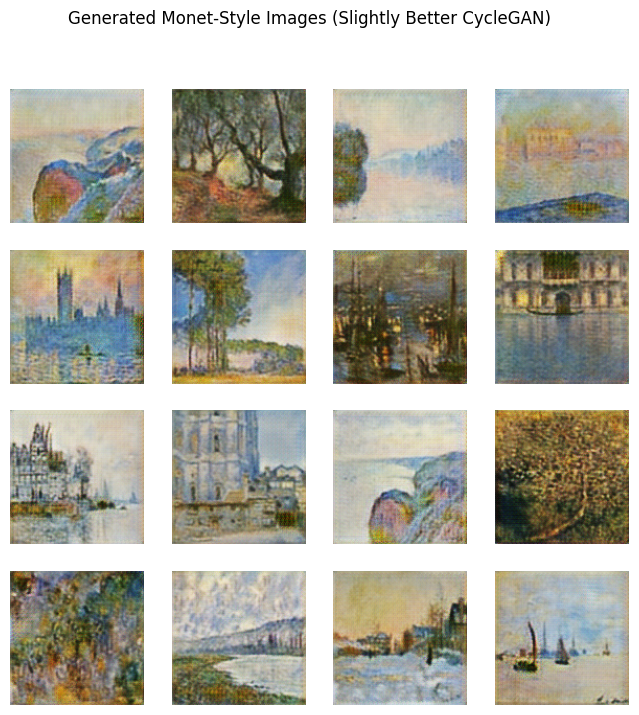

In [30]:
# Generate new Monet-style images
generated_images = generator(monet_images[:16], training=False)

plt.figure(figsize=(8,8))
for i in range(generated_images.shape[0]):
    plt.subplot(4,4,i+1)
    img = (generated_images[i] + 1) / 2
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Generated Monet-Style Images (Slightly Better CycleGAN)')
plt.show()


## 7. Conclusion

Starting from a simple GAN that produced weird, identical blobs to now seeing actual Monet-style paintings felt like a big learning moment. The slight upgrades to the model made a major difference in training stability and final image quality. Because our dataset was relatively small and our model didn’t use strong randomness or heavy data augmentation, it’s not surprising that some generated images look pretty similar to real Monet paintings. CycleGANs especially are designed to preserve structure while changing style, so if the generator sees the same patterns a lot, it can start reusing them in outputs. If I had more time, I would definitely train for more epochs (probably 50–100) and maybe add techniques like learning rate decay or identity loss to sharpen the images even further. But for a mini-project like this, I’m really happy with how CycleGAN performed.

## 8. Preparing 7000+ generated Monet images for Kaggle submission

In [33]:
# Keggle stuff
import zipfile
from tqdm.notebook import tqdm

# folder for generated images
output_folder = 'generated_images'
os.makedirs(output_folder, exist_ok=True)

# number of images to generate
TOTAL_IMAGES = 7000
BATCH_SIZE = 64

generated_count = 0

# generate and save images
while generated_count < TOTAL_IMAGES:
    current_batch_size = min(BATCH_SIZE, TOTAL_IMAGES - generated_count)
    
    random_inputs = tf.random.normal([current_batch_size, 128, 128, 3])

    fake_images = generator(random_inputs, training=False)

    for img in fake_images:
        img = (img + 1) / 2  # rescale to [0,1]
        img = tf.image.resize(img, [256, 256])  # resize to 256x256
        img_array = (img.numpy() * 255).astype(np.uint8)
        img_pil = Image.fromarray(img_array)
        img_pil.save(os.path.join(output_folder, f"{generated_count}.jpg"))
        generated_count += 1

print(f"Generated {generated_count} images.")

Generated 7000 images.


## 9. Zipping all images into images.zip

In [34]:
# images.zip
zip_filename = 'images.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, dirs, files in os.walk(output_folder):
        for file in tqdm(files):
            zipf.write(os.path.join(root, file), arcname=file)

print("images.zip created successfully!")

  0%|          | 0/7000 [00:00<?, ?it/s]

images.zip created successfully!
